In [5]:
using CUDA
CUDA.versioninfo()

CUDA runtime 12.4, artifact installation
CUDA driver 12.4
NVIDIA driver 535.161.8, originally for CUDA 12.2

CUDA libraries: 
- CUBLAS: 12.4.5
- CURAND: 10.3.5
- CUFFT: 11.2.1
- CUSOLVER: 11.6.1
- CUSPARSE: 12.3.1
- CUPTI: 22.0.0
- NVML: 12.0.0+535.161.8

Julia packages: 
- CUDA: 5.3.5
- CUDA_Driver_jll: 0.8.1+0
- CUDA_Runtime_jll: 0.12.1+0

Toolchain:
- Julia: 1.10.3
- LLVM: 15.0.7

1 device:
  0: Tesla T4 (sm_75, 14.437 GiB / 15.000 GiB available)


In [6]:
using FileIO, Colors, BenchmarkTools, ImageShow

In [7]:
typeof(Complex(1.0,4.0))

ComplexF64 (alias for Complex{Float64})

In [8]:
function juliaset(z0, maxiter)
    c = ComplexF32(-0.5, 0.75)
    z = z0
    for i in 1:maxiter
        abs2(z) > 4f0 && return (i - 1) % UInt8
        z = z * z + c
    end
    return maxiter % UInt8 # % is used to convert without overflow check
end

juliaset (generic function with 1 method)

In [12]:
const q = [ComplexF32(r, i) for i=1:-(2.0/(2^10)):-1, r=-1.5:(3.0/(2^10)):1.5]
const qCuda = CuArray(q);



In [14]:
@time CuArray(q);

  0.001864 seconds (16 allocations: 400 bytes)


In [29]:
function calcCPU(q, res)
    res .= juliaset.(q, 16)
end
function calcGPU(q, res)    
    res .= juliaset.(q, 16)
    CUDA.synchronize()
end

calcGPU (generic function with 1 method)

In [16]:
const res_cpu = zeros(UInt8, size(q))
const res_gpu = CuArray(zeros(UInt8, size(q)));

In [17]:
@time calcCPU(q, res_cpu)
@time calcCPU(q, res_cpu);

  0.014063 seconds
  0.013954 seconds


In [30]:
@time calcGPU(qCuda, res_gpu)
@time calcGPU(qCuda, res_gpu)

  0.000129 seconds (73 allocations: 2.094 KiB)
  0.000122 seconds (58 allocations: 1.516 KiB)


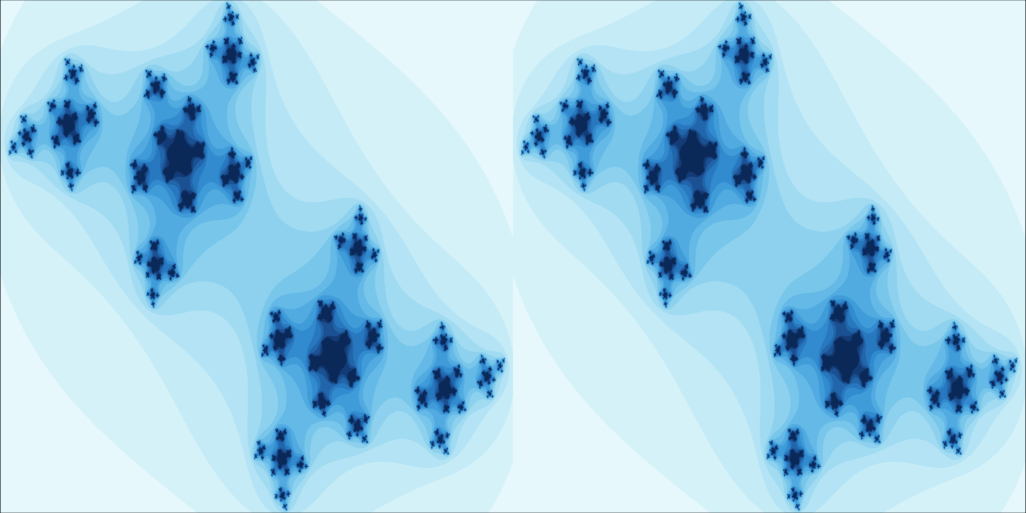

In [31]:
cu_jl = hcat(Array(res_gpu), res_cpu)
cmap = colormap("Blues", 16 + 1)
color_lookup(val, cmap) = cmap[val + 1]
color_lookup.(cu_jl, (cmap,))